In [405]:
from IPython.display import display, HTML

In [406]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [407]:
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [408]:
CSS = """
.output {
    align-items: center;
}
"""
HTML('<style>{}</style>'.format(CSS))

In [409]:
import numpy as np
import pandas as pd

from pandas import Series, DataFrame

from __future__ import division
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [410]:
deaths = pd.read_csv("/Users/earleaguilar/DataSets/DeathRecords/DeathRecords.csv")

# Analysis of Death Records in the United States 2015

Here I analyze mortality data provided by the CDC under the National Vital Statistics Systems. This set contains a record of every death in the United States in the year 2015. In addition the set includes detailed information about the causes of death and the demographic background of the deceased.

In this exploratory data analysis I might hope to answer the following questions when possible.

1. Is there a month in which people die more?

2. Does race/ethnicity affect age of death?

3. Does education play into the age of death of a person?

4. Where do people die the most conditioned on race/ethnicity?

5. How are their bodies disposed? 

6. Does marital status affect the age a person dies?

In addition I intend to analyze certain causes of death in more detail and how they affect race/ethnic groups.

In [411]:
deaths = deaths[(deaths['EducationReportingFlag'] == 1) | (deaths['EducationReportingFlag'] == 2)]

In [412]:
# Using the codes and their meanings I convert all ages to years. 

def age_convert_2_years(info):
    tag,age = info
    if tag == 1: # 1 is for years
        return age
    elif tag == 2: # 2 is for 
        return age/12
    elif tag == 4: # 4 is for
        return age/365
    elif tag == 5: # 5 is for
        return age/8760
    elif tag == 6: # 6 is for
        return age/525600
    elif tag == 9: # 9 is for
        return np.nan
    
deaths['Mod_age'] = deaths[['AgeType','Age']].apply(age_convert_2_years, axis=1)    

# After having made the conversion to years any date such as 999.0 are probably incorrect.

deaths = deaths[deaths.Mod_age != 999.0] 

# I drop rows which contain NaNs since I will be making use of many of the attributes and a missing 
# attribute will not be useful.
deaths = deaths.dropna()

# One of the methods of disposition is "unidentified" so I just drop it here in order for my plots
# to make sense
deaths = deaths[(deaths.MethodOfDisposition == 'B') | (deaths.MethodOfDisposition == 'C') | (deaths.MethodOfDisposition == 'U') | (deaths.MethodOfDisposition == 'O')]

### Age of Death

The following histogram shows the distribution of deaths in the united states. The median age of death is 77 years. The bump at 0 are the deaths of children that died at birth or before they were 1. 

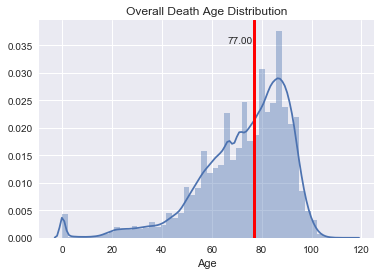

In [413]:
med = deaths.Mod_age.median()
sns.distplot(deaths.Mod_age)
plt.axvline(x=med, linewidth=3, color='r')
plt.figtext(0.56,0.8, "%.2f" %med)
plt.title("Overall Death Age Distribution")
plt.xlabel('Age')

In [414]:
# Here I classify ICD10 codes

def classify_disease(marker):
    if marker[0] == 'A' or  marker[0] == 'B':
        return "Certain infectious and parasitic diseases"
    elif marker[0] == 'C':
        return "Neoplasms"
    elif marker[0] == 'D':
        if int(marker[1:3]) < 40:
            return "Neoplasms"
        else: 
            return "Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism" 
    elif marker[0] == 'E':
        return "Endocrine, nutritional and metabolic diseases"
    elif marker[0] == 'F':
        return "Mental, Behavioral and Neurodevelopmental disorders"
    elif marker[0] == 'G':
        return "Diseases of the nervous system"
    elif marker[0] == 'H':
        if int(marker[1:3]) < 60:  
            return "Diseases of the eye and adnexa"
        else:
            return "Diseases of the ear and mastoid process"
    elif marker[0] == 'I':
        return "Diseases of the circulatory system"
    elif marker[0] == 'J':
        return "Diseases of the respiratory system"
    elif marker[0] == 'K':
        return "Diseases of the digestive system"
    elif marker[0] == 'L':
        return "Diseases of the skin and subcutaneous tissue"
    elif marker[0] == 'M':
        return "Diseases of the musculoskeletal system and connective tissue"
    elif marker[0] == 'N':
        return "Diseases of the genitourinary system"
    elif marker[0] == 'O':
        return "Pregnancy, childbirth and the puerperium"
    elif marker[0] == 'P':
        return "Certain conditions originating in the perinatal period"
    elif marker[0] == 'Q':
        return "Congenital malformations, deformations and chromosomal abnormalities"
    elif marker[0] == 'R':
        return "Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified"
    elif marker[0] == 'S' or marker[0] == 'T':
        return "Injury, poisoning and certain other consequences of external causes"
    elif marker[0] == 'V' or marker[0] == 'W' or marker[0] == 'X' or marker[0] == 'Y':
        return "External causes of morbidity"
    elif marker[0] == 'Z':
        return "Factors influencing health status and contact with health services"
    
deaths['Diagnosis'] = deaths['Icd10Code'].apply(classify_disease)    

I will now seperate the groups into three white, black, and hispanic, it will be insightful to see how death affects these three groups seperately.

I will split hispanics as Mexicans, South and Central Americans. I will neglect Cubans and Puerto Ricans because of the socio-political environments which in my opinion have shaped those two countries differently than the other countries.

In [415]:
hispanic = deaths[(deaths.HispanicOriginRaceRecode == 1) | (deaths.HispanicOriginRaceRecode == 4)]
black = deaths[deaths.RaceRecode3 == 3]
white = deaths[deaths.RaceRecode3 == 1]

### Does the month play a role in death?
The plots below seem to indicate that death does not discriminate on which month people die based on race. In addition the plot shows that there is a trend as winter comes deaths rises and begins to decrease during spring.

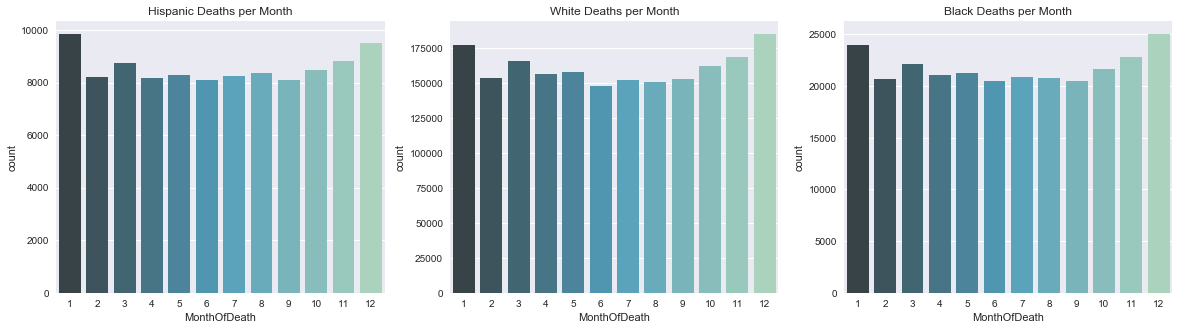

In [416]:
plt.figure(figsize=(20,5)) 

plt.subplot(1, 3, 1)
sns.countplot(x='MonthOfDeath',data=hispanic,palette='GnBu_d')
plt.title("Hispanic Deaths per Month")
plt.subplot(1, 3, 2)
sns.countplot(x='MonthOfDeath',data=white,palette='GnBu_d')
plt.title("White Deaths per Month")
plt.subplot(1, 3, 3)
sns.countplot(x='MonthOfDeath',data=black,palette='GnBu_d')
plt.title("Black Deaths per Month")

### Does race/ethnicity affect age of death?
The following graphs indicate that Hispanic and Black people have a higher degree of infant death with Hispanic infant death accounting for approximately 1.6% of the population and Black infant death accounting for 1.2% of the population. White infant death on the other hand accounts for less than .5% of the population. 

The distribution of ages is also different for the three groups both black and hispanics have a median age of 68 years 
however black people will die at approximately the same frequency slightly before 68 years and after 68 wheras hispanic people will tend to die at an increasing rate after 68. White people on the other hand have a median death age of 78 years with little variation among the group. So on average white people tend to live 10 years more than black and hispanic people. 

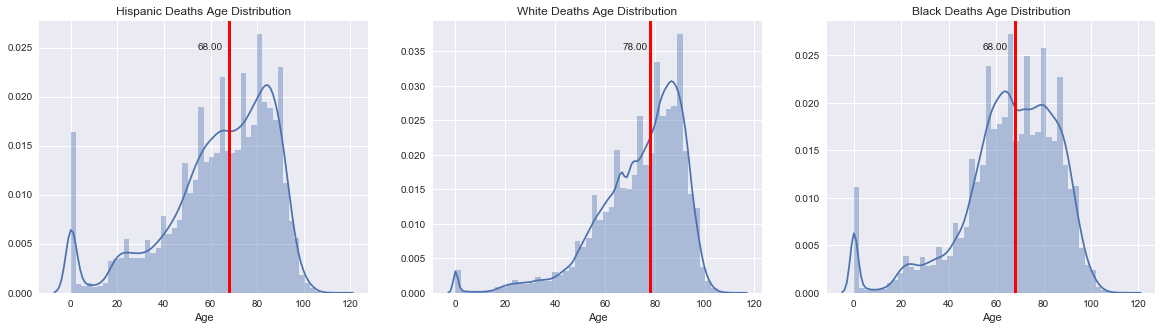

In [417]:
h_median = hispanic.Mod_age.median()
w_median = white.Mod_age.median()
b_median = black.Mod_age.median()

plt.figure(figsize=(20,5)) 

plt.subplot(1, 3, 1)
sns.distplot(hispanic.Mod_age)
plt.axvline(x=h_median, linewidth=3, color='r')
plt.figtext(0.235,0.8, "%.2f" %h_median)
plt.title("Hispanic Deaths Age Distribution")
plt.xlabel('Age')
plt.subplot(1, 3, 2)
sns.distplot(white.Mod_age)
plt.axvline(x=w_median, linewidth=3, color='r')
plt.figtext(0.53,0.8, "%.2f" %w_median)
plt.title("White Deaths Age Distribution")
plt.xlabel('Age')
plt.subplot(1, 3, 3)
sns.distplot(black.Mod_age)
plt.axvline(x=b_median, linewidth=3, color='r')
plt.figtext(0.78,0.8, "%.2f" %b_median)
plt.title("Black Deaths Age Distribution")
plt.xlabel('Age')

### Does education play into the age of death of a person?

The following education groups are classified as such:

1. 8th grade or less
2. 9-12th grade, no diploma
3. High school gradutate or GED completed
4. Some college credit, but no degree
5. Associate Degree
6. Bachelor's Degree
7. Master's Degree
8. Doctorate or Professional Degree

The boxplots below show that an increase in education does not increase the age of death significanly for individuals in either group. As a matter of fact the data seems to indicate that on average individuals with an education that is at most 8th grade have higher death ages than any other group. This is interesting because my assumption was that as an individual aquires more education he/she also becomes informed on the lifestyle behaviors which can help maximize the age of death. In addition hispanic and black people have approximately the same average age of death across all education levels, on the other hand white people tend to have higher age of death averages throught all education levels.

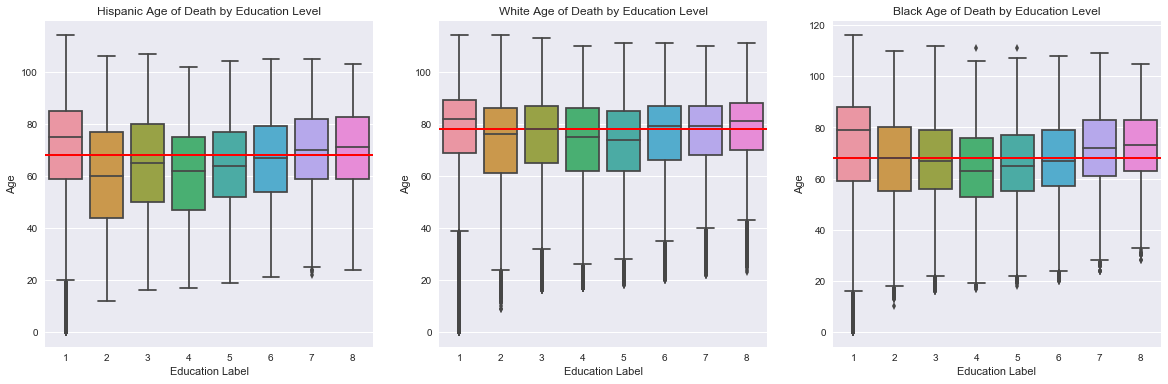

In [418]:
plt.figure(figsize=(20,6)) 

plt.subplot(1, 3, 1)
sns.boxplot(x='Education2003Revision', y='Mod_age', data=hispanic[hispanic.Education2003Revision != 9])
plt.title("Hispanic Age of Death by Education Level")
plt.ylabel("Age")
plt.xlabel("Education Label")
plt.axhline(y=hispanic.Mod_age.median(), linewidth=2, color='r')
plt.subplot(1, 3, 2)
sns.boxplot(x='Education2003Revision', y='Mod_age', data=white[white.Education2003Revision != 9])
plt.title("White Age of Death by Education Level")
plt.ylabel("Age")
plt.xlabel("Education Label")
plt.axhline(y=white.Mod_age.median(), linewidth=2, color='r')
plt.subplot(1, 3, 3)
sns.boxplot(x='Education2003Revision', y='Mod_age', data=black[black.Education2003Revision != 9])
plt.title("Black Age of Death by Education Level")
plt.ylabel("Age")
plt.xlabel("Education Label")
plt.axhline(y=black.Mod_age.median(), linewidth=2, color='r')

### Where do people die the most conditioned on attributes ethnicity/race? 

Place of death is coded into this dataset as follows:

1\. Hospital, clinic or Medical Center - Inpatient <br>
2\. Hospital, Clinic or Medical Center - Outpatient or admitted to Emergency Room <br>
3\. Hospital, Clinic or Medical Center - Dead on Arrival <br>
4\. Decedent's home <br>
5\. Hospice facility <br>
6\. Nursing home/long term care <br>
7\. Other <br>
9\. Place of death unknown 

The main 3 places of death for all groups are 

1. Hospital, clinic or Medical Center - Inpatient
2. Decedent's home
3. Nursing home/long term care

One thing to notice is that white people specially have approximately the same number of individuals die at home than as inpatients and in addition they have a disproportionally higher percentage of deaths occur at nursing homes.


The next two places of death for all three groups slightly differ 


Hispanic

4\. Hospital, Clinic or Medical Center - Outpatient or admitted to Emergency Room <br>
5\. Other <br>

Black 

4\. Hospital, Clinic or Medical Center - Outpatient or admitted to Emergency Room <br>
5\. Hospice facility  <br>

White

4\. Hospice facility  <br>
5\. Hospital, Clinic or Medical Center - Outpatient or admitted to Emergency Room <br>

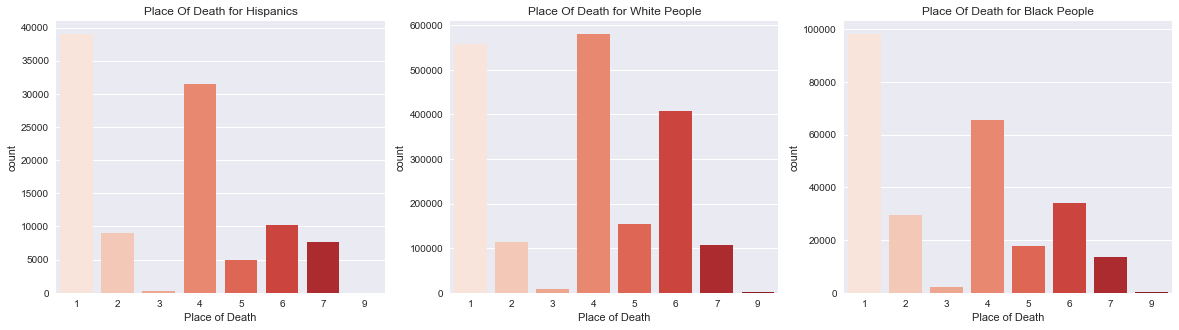

In [419]:
plt.figure(figsize=(20,5)) 

plt.subplot(1, 3, 1)
sns.countplot(x='PlaceOfDeathAndDecedentsStatus',data=hispanic,palette='Reds')
plt.title("Place Of Death for Hispanics")
plt.xlabel('Place of Death')
plt.subplot(1, 3, 2)
sns.countplot(x='PlaceOfDeathAndDecedentsStatus',data=white,palette='Reds')
plt.title("Place Of Death for White People")
plt.xlabel('Place of Death')
plt.subplot(1, 3, 3)
sns.countplot(x='PlaceOfDeathAndDecedentsStatus',data=black,palette='Reds')
plt.title("Place Of Death for Black People")
plt.xlabel('Place of Death')

### How are bodies disposed?

Burials are the most common method of disposition among all three groups. White and hispanics have a higher number of cremations. Specifically white people have almost equal number of cremations as burials. I wonder if this is a result of the cost analysis of burials vs cremations and using it to guide ones choice to be cremated or to cremate a loved one. 

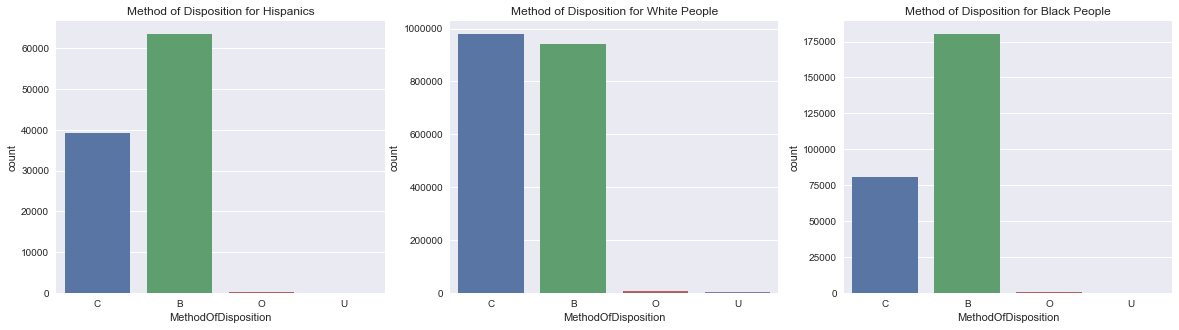

In [420]:
plt.figure(figsize=(20,5)) 

plt.subplot(1, 3, 1)
sns.countplot('MethodOfDisposition',data=hispanic)
plt.title("Method of Disposition for Hispanics")
plt.subplot(1, 3, 2)
sns.countplot('MethodOfDisposition',data=white)
plt.title("Method of Disposition for White People")
plt.subplot(1, 3, 3)
sns.countplot('MethodOfDisposition',data=black)
plt.title("Method of Disposition for Black People")

### Does marital status affect the age a person dies?

Marital status does seem to have an effect on how long one lives. Married and divorced individuals in each group tend to have the same life spans; married people edging divorcees slightly. Interestingly white married/divorced people on average live less than the actual white population average. Widowers have the longest lifespans and on average have at least 10 years of more life than the other groups. Single people die younger in all three groups for all three groups single people on average die at ages below the average age of death per group. In addition single hispanics have a significatly lower lifespan than black and white people.

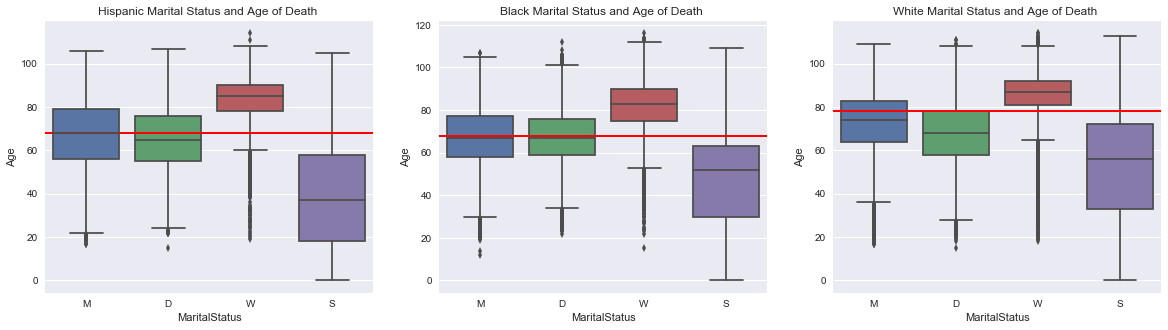

In [421]:
plt.figure(figsize=(20,5)) 

cols = ['M', 'D','W','S']
plt.subplot(1,3,1)
sns.boxplot(x='MaritalStatus', y='Mod_age', data=hispanic,order=cols)
plt.title("Hispanic Marital Status and Age of Death ")
plt.ylabel('Age')
plt.axhline(y=hispanic.Mod_age.median(), linewidth=2, color='r')
plt.subplot(1,3,2)
sns.boxplot(x='MaritalStatus', y='Mod_age', data=black,order=cols)
plt.title("Black Marital Status and Age of Death ")
plt.ylabel('Age')
plt.axhline(y=black.Mod_age.median(), linewidth=2, color='r')
plt.subplot(1,3,3)
sns.boxplot(x='MaritalStatus', y='Mod_age', data=white,order=cols)
plt.title("White Marital Status and Age of Death ")
plt.ylabel('Age')
plt.axhline(y=white.Mod_age.median(), linewidth=2, color='r')

### What diseases affect race/ethnicity?

The three groups are vastly affected by diseases of the circulatory system which is no suprise since the leading cause of death according to the CDC is heart disease. The next common diseases are neoplasms both malignant and benign. External causes of morbidity and diseases of the respiratory system affect black and hispanics in that respective order but for white people the order is reversed. 

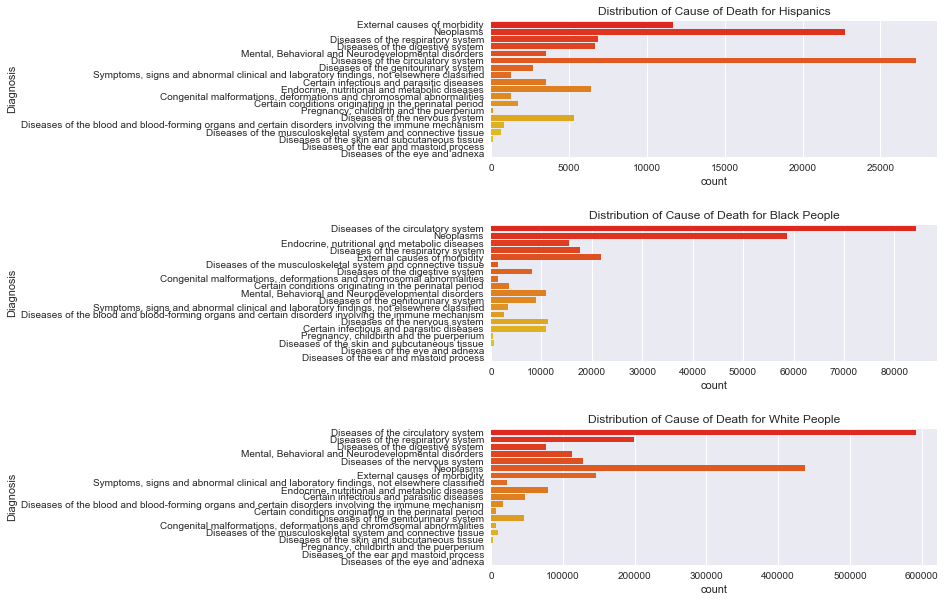

In [422]:
plt.figure(figsize=(8,10)) 

plt.subplot(3,1,1)
sns.countplot(y='Diagnosis',data=hispanic,palette='autumn')
plt.title("Distribution of Cause of Death for Hispanics")
plt.subplot(3,1,2)
sns.countplot(y='Diagnosis',data=black,palette='autumn')
plt.title("Distribution of Cause of Death for Black People")
plt.subplot(3,1,3)
sns.countplot(y='Diagnosis',data=white,palette='autumn')
plt.title("Distribution of Cause of Death for White People")

plt.subplots_adjust(hspace=.5)

# I will analyze certain causes of death with more emphasis.

I will analyze how suicide, cardiovascular disease, and malignant neoplasms present themselves among these deaths and if there are any particular subgroups which are significantly affected or not affected by them.

## Suicide

Here I use the ICD10codes for intentional self-harm which are codefied as such:

 Intentional self-harm by:
 
1. X71 - drowning and submersion
2. X72 - handgun discharge
3. X73 - rifle, shotgun and larger firearm discharge
4. X74 - other and unspecified firearm and gun discharge
5. X75 - explosive material
6. X76 - smoke, fire and flames
7. X77 - steam, hot vapors and hot objects
8. X78 - sharp object
9. X79 - blunt object
10. X80 - jumping from a high place
11. X81 - jumping or lying in front of moving object
12. X82 - crashing of motor vehicle
13. X83 - other specified means

In [423]:
suicide = deaths[deaths.Icd10Code.str.contains('X[7]{1}[1,2,3,4,5,6,7,8,9]+|X[8]{1}[0,1,2,3]+', regex=True)]

The top 3 leading causes of suicide in this set are 

1. Intentional self-harm by other and unspecified firearm and gun discharge" (X74) 
2. Intentional self-harm by handgun discharge" (X72) 
3. Intentional self-harm by rifle, shotgun and larger firearm discharge" (X73). These are all methods in which a gun was used.

The next top 3 are 

1. Intentional self-harm by jumping from a high place (X80) 
2. Intentional self-harm by sharp object (X78) 
3. Intentional self-harm by jumping or lying in front of moving object (X81).

Showing the distributions of methods for suicide for sexes show in all of these methods men outnumber women in choosing the aforementioned methods to end their life. More importantly men significantly outnumber women in commiting suicide.

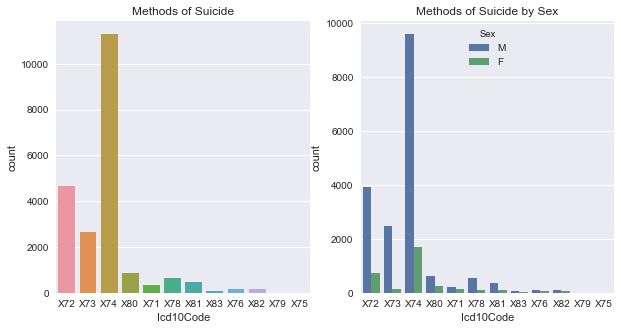

In [424]:
plt.figure(figsize=(10,5)) 

plt.subplot(1,2,1)
sns.countplot('Icd10Code',data=suicide)
plt.title("Methods of Suicide")
plt.subplot(1,2,2)
sns.countplot('Icd10Code',data=suicide, hue='Sex')
plt.title("Methods of Suicide by Sex")

The following histogram shows a  bimodal distribution of those who have attempted suicide. A group in their early 20's and a group in their 50's. I will attempt to condition the age of suicice by certain factors in an in orde
to see if I can discover what groups create the bimodal distribution or if its solely a result of age.

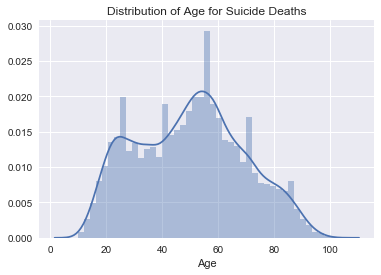

In [467]:
sns.distplot(suicide.Mod_age)

plt.title("Distribution of Age for Suicide Deaths")
plt.xlabel('Age')os.environ['PATH'] 

Seperating by sex continues to show that there is still more than one group that commit sucides. Analyzing them seperately we can observe that for men the first group of suicides peak in the mid twenties and the second group peaks in the late fifties. For women on the other hand the first group peaks slighly later around the 30's and the second group peaks slightly earlier somewhere in the early 50's. The decrease of suicides after 60 reduces significantly for women where as for men the decrease is slower.

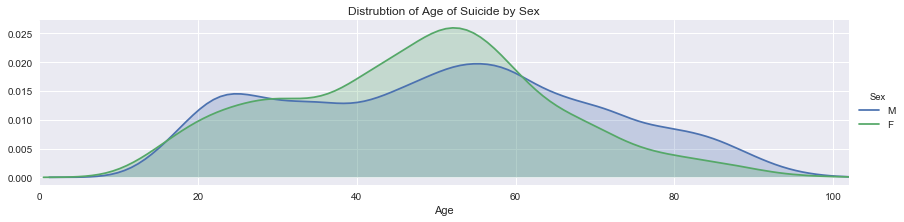

In [426]:
fig = sns.FacetGrid(suicide, hue='Sex', aspect=4)

fig.map(sns.kdeplot, 'Mod_age' , shade=True)

oldest = suicide['Mod_age'].max()

# Setting the limits
fig.set(xlim=(0,oldest))

# This is how to add a legen
fig.add_legend()

plt.title("Distrubtion of Age of Suicide by Sex")
plt.xlabel('Age')

I split suicide attemps by marital status and here we can see that maybe the two groups present in the earlier 
graphs might be "Single" as one group and "married", "divorced", and "widowed" as the second group. I will investigate further to determine if this could be the cause of the bimodal distribution I saw earlier. 

However from the graph we can see that Single people tend to commit suicide earlier in life at 29. Married and divorced people both commit suicide on average at the same age 55, divorcees doing it with more frequency than married individuals. Finally widowers commit suicide much later in life at 78. I wonder if this is as a result of having lost their significant others and the lack of want to continue living without them. 

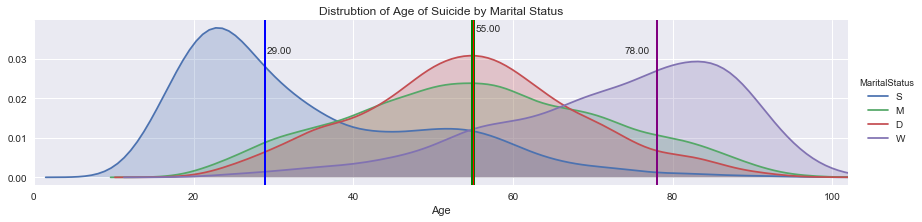

In [427]:
fig = sns.FacetGrid(suicide[suicide.MaritalStatus != 'U'], hue='MaritalStatus', aspect=4)

fig.map(sns.kdeplot, 'Mod_age' , shade=True)

oldest = suicide['Mod_age'].max()

# Setting the limits
fig.set(xlim=(0,oldest))

# This is how to add a legen
fig.add_legend()

plt.title("Distrubtion of Age of Suicide by Marital Status")
plt.xlabel('Age')


s_median = suicide[suicide.MaritalStatus == 'S'].Mod_age.median()
m_median = suicide[suicide.MaritalStatus == 'M'].Mod_age.median()
d_median = suicide[suicide.MaritalStatus == 'D'].Mod_age.median()
W_median = suicide[suicide.MaritalStatus == 'W'].Mod_age.median()

plt.axvline(x=s_median, linewidth=2, color='b')
plt.axvline(x=m_median, linewidth=4, color='g')
plt.axvline(x=d_median, linewidth=1, color='r')
plt.axvline(x=w_median, linewidth=2, color='purple')

plt.figtext(0.295,0.8, "%.2f" %s_median)
plt.figtext(0.52,0.9, "%.2f" %d_median)
plt.figtext(0.68,0.8, "%.2f" %w_median)

Here I plot the groups up individually to show that with the exception of the "Single" group every other group follows a normal distribution. I will continue the analysis of suicide on the population by making split among these groups and analysing them individually.

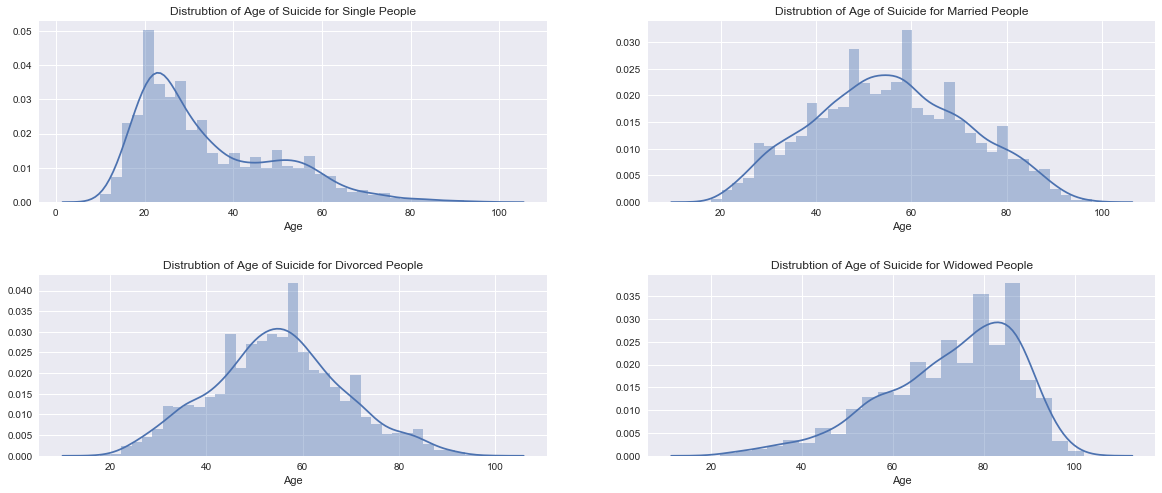

In [428]:
single = suicide[suicide.MaritalStatus == 'S']
married = suicide[suicide.MaritalStatus == 'M']
divorced = suicide[suicide.MaritalStatus == 'D']
widowed  = suicide[suicide.MaritalStatus == 'W']

plt.figure(figsize=(20,8)) 
plt.subplot(2,2,1)
sns.distplot(single.Mod_age)
plt.title("Distrubtion of Age of Suicide for Single People")
plt.xlabel('Age')
plt.subplot(2,2,2)
sns.distplot(married.Mod_age)
plt.title("Distrubtion of Age of Suicide for Married People")
plt.xlabel('Age')
plt.subplot(2,2,3)
sns.distplot(divorced.Mod_age)
plt.title("Distrubtion of Age of Suicide for Divorced People")
plt.xlabel('Age')
plt.subplot(2,2,4)
sns.distplot(widowed.Mod_age)
plt.title("Distrubtion of Age of Suicide for Widowed People")
plt.xlabel('Age')

plt.subplots_adjust(hspace=.4)

### Suicide and Education
I will now study the effect of education on suicide for each one of these 4 groups. I will only analyze four stages of education level. I feel these span the spectrum of education and increase ones academic status significicantly compared to the one before it. These four groups are:

1. (1) 8th grade or less
2. (3) High school graduate or GED completed
3. (6) Bachelor's degree
4. (8) Doctorate or professional degree

#### Single People
From the plot we can see that for single people the average age of suicide is increasing as the education level rises. Additionally the frequency of suicides begins to decrease with an increase of education. Group 1 commits suicide on average at 15 and groups 3 and 6 attempt suicide at 30 and 37 respectively. For group 8 however suicide is low until mid after their 20's and on average this group attemps suicide at 47 and does not decrease much as the group ages.

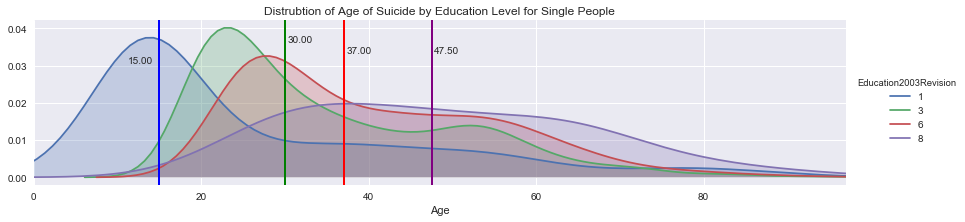

In [429]:
suicide_by_educ = single[(single.Education2003Revision == 1) | (single.Education2003Revision == 3) |
                         (single.Education2003Revision == 6) | (single.Education2003Revision == 8)]

fig = sns.FacetGrid(suicide_by_educ, hue='Education2003Revision', aspect=4)

fig.map(sns.kdeplot, 'Mod_age' , shade=True)

oldest = suicide_by_educ['Mod_age'].max()

# Setting the limits
fig.set(xlim=(0,oldest))

# This is how to add a legen
fig.add_legend()
plt.title("Distrubtion of Age of Suicide by Education Level for Single People")
plt.xlabel('Age')


one_median = single[single.Education2003Revision == 1].Mod_age.median()
three_median = single[single.Education2003Revision == 3].Mod_age.median()
six_median = single[single.Education2003Revision == 6].Mod_age.median()
eight_median = single[single.Education2003Revision == 8].Mod_age.median()

plt.axvline(x=one_median, linewidth=2, color='b')
plt.axvline(x=three_median, linewidth=2, color='g')
plt.axvline(x=six_median, linewidth=2, color='r')
plt.axvline(x=eight_median, linewidth=2, color='purple')

plt.figtext(0.14,0.75, "%.2f" %one_median)
plt.figtext(0.305,0.85, "%.2f" %three_median)
plt.figtext(0.365,0.8, "%.2f" %six_median)
plt.figtext(0.455,0.8, "%.2f" %eight_median)

#### Married People
For married indiviuals being in groups 3 and 6 will place the average age of suicide at 55 and 56 years respectively, however there is a lot of variation among these groups. Having a PHD or a professional degree will shift the average age to 61 and having no education will significanly shift the average age to 70. So in effect being married and having less than an 8th grade education will increase the average age of death by suicide. Then the trend of an increasing age of suicide further as the education level increases will arise.

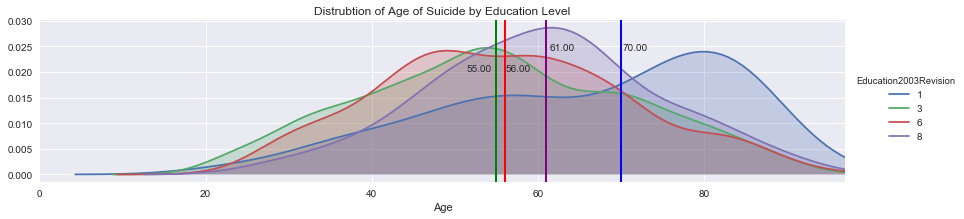

In [462]:
suicide_by_educ = married[(married.Education2003Revision == 1) | (married.Education2003Revision == 3) |
                         (married.Education2003Revision == 6) | (married.Education2003Revision == 8)]

fig = sns.FacetGrid(suicide_by_educ, hue='Education2003Revision', aspect=4)

fig.map(sns.kdeplot, 'Mod_age' , shade=True)

oldest = suicide_by_educ['Mod_age'].max()

# Setting the limits
fig.set(xlim=(0,oldest))

# This is how to add a legen
fig.add_legend()
plt.title("Distrubtion of Age of Suicide by Education Level")
plt.xlabel('Age')

one_median = married[married.Education2003Revision == 1].Mod_age.median()
three_median = married[married.Education2003Revision == 3].Mod_age.median()
six_median = married[married.Education2003Revision == 6].Mod_age.median()
eight_median = married[married.Education2003Revision == 8].Mod_age.median()

plt.axvline(x=one_median, linewidth=2, color='b')
plt.axvline(x=three_median, linewidth=2, color='g')
plt.axvline(x=six_median, linewidth=2, color='r')
plt.axvline(x=eight_median, linewidth=2, color='purple')

plt.figtext(0.49,0.70, "%.2f" %three_median)
plt.figtext(0.53,0.7, "%.2f" %six_median)
plt.figtext(0.575,0.8, "%.2f" %eight_median)
plt.figtext(0.65,0.8, "%.2f" %one_median)

#### Divorcees
The same is true for divorced indivuals in the fact that an 8th grade education increases the age of suicide more significanly than the other education levels. However this age is shifted left and now the average age of death for group 1 is 66. Then once again the more educated an individual is the more the age of suicide increases. The difference is that now a PHD degree will commit suicide on average earlier as a divorcee than as a married individual at 58 years . In addition for groups 1,3, and 6 the variation is diminished and the distribution is more normal. This could be as a result of a divorce being a negative experience making suicide among this group more likely.

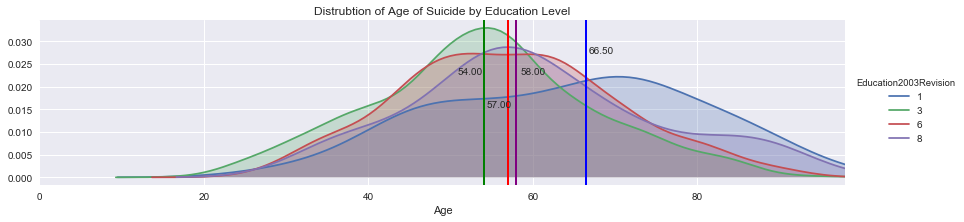

In [463]:
suicide_by_educ = divorced[(divorced.Education2003Revision == 1) | (divorced.Education2003Revision == 3) |
                         (divorced.Education2003Revision == 6) | (divorced.Education2003Revision == 8)]

fig = sns.FacetGrid(suicide_by_educ, hue='Education2003Revision', aspect=4)

fig.map(sns.kdeplot, 'Mod_age' , shade=True)

oldest = suicide_by_educ['Mod_age'].max()

# Setting the limits
fig.set(xlim=(0,oldest))

# This is how to add a legen
fig.add_legend()
plt.title("Distrubtion of Age of Suicide by Education Level")
plt.xlabel('Age')

one_median = divorced[divorced.Education2003Revision == 1].Mod_age.median()
three_median = divorced[divorced.Education2003Revision == 3].Mod_age.median()
six_median = divorced[divorced.Education2003Revision == 6].Mod_age.median()
eight_median = divorced[divorced.Education2003Revision == 8].Mod_age.median()

plt.axvline(x=one_median, linewidth=2, color='b')
plt.axvline(x=three_median, linewidth=2, color='g')
plt.axvline(x=six_median, linewidth=2, color='r')
plt.axvline(x=eight_median, linewidth=2, color='purple')

plt.figtext(0.48,0.70, "%.2f" %three_median)
plt.figtext(0.51,0.55, "%.2f" %six_median)
plt.figtext(0.545,0.7, "%.2f" %eight_median)
plt.figtext(0.615,0.8, "%.2f" %one_median)

#### Widows
Widowers of all education groups create left skewed distributions. There are two pairs of groups that follow approximatley the same distribution; groups 3 and 6 have more variation in comparison to groups 1 and 8. Groups 3 and 6 commit suicide earlier around at 75 and 77 respectively. On the other hand groups 1 and 8 commit suicide later at 81 and 82 respectively.

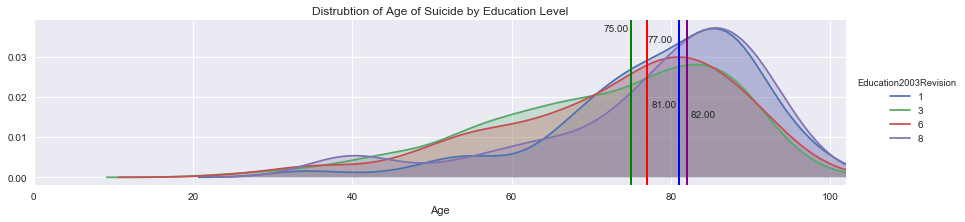

In [464]:
suicide_by_educ = widowed[(widowed.Education2003Revision == 1) | (widowed.Education2003Revision == 3) |
                         (widowed.Education2003Revision == 6) | (widowed.Education2003Revision == 8)]

fig = sns.FacetGrid(suicide_by_educ, hue='Education2003Revision', aspect=4)

fig.map(sns.kdeplot, 'Mod_age' , shade=True)

oldest = suicide_by_educ['Mod_age'].max()

# Setting the limits
fig.set(xlim=(0,oldest))

# This is how to add a legen
fig.add_legend()
plt.title("Distrubtion of Age of Suicide by Education Level")
plt.xlabel('Age')

one_median = widowed[widowed.Education2003Revision == 1].Mod_age.median()
three_median = widowed[widowed.Education2003Revision == 3].Mod_age.median()
six_median = widowed[widowed.Education2003Revision == 6].Mod_age.median()
eight_median = widowed[widowed.Education2003Revision == 8].Mod_age.median()

plt.axvline(x=one_median, linewidth=2, color='b')
plt.axvline(x=three_median, linewidth=2, color='g')
plt.axvline(x=six_median, linewidth=2, color='r')
plt.axvline(x=eight_median, linewidth=2, color='purple')

plt.figtext(0.63,0.9, "%.2f" %three_median)
plt.figtext(0.675,0.85, "%.2f" %six_median)
plt.figtext(0.68,0.55, "%.2f" %one_median)
plt.figtext(0.72,0.50, "%.2f" %eight_median)

### Suicides by race/ethinicity

Here I go back to the original suicide split of the dataset and simply split by race/ethnicity once again I am splitting Hispanics, black people, and white people. 

In [433]:
suicide_hispanic = suicide[(suicide.HispanicOriginRaceRecode == 1) | (suicide.HispanicOriginRaceRecode == 4)]
suicide_black = suicide[suicide.RaceRecode3 == 3]
suicide_white = suicide[suicide.RaceRecode3 == 1]

Observing the distribution for hispanics we see that the bimodal distribution is not present and in fact we have a right skewed distribution with a lot of variation. Males commit sucide at 32 and females commit suicide at 35. 

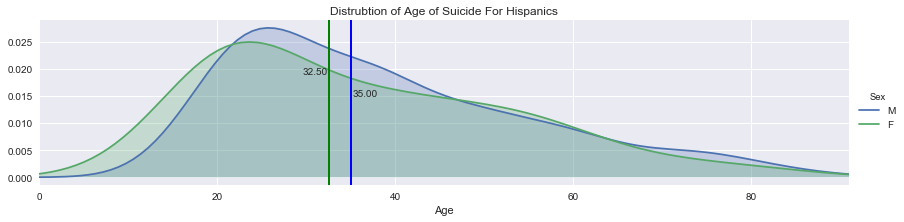

In [434]:
fig = sns.FacetGrid(suicide_hispanic, hue='Sex', aspect=4)

fig.map(sns.kdeplot, 'Mod_age' , shade=True)

oldest = suicide_hispanic['Mod_age'].max()

# Setting the limits
fig.set(xlim=(0,oldest))

# This is how to add a legen
fig.add_legend()

plt.title("Distrubtion of Age of Suicide For Hispanics")
plt.xlabel('Age')

female_median = suicide_hispanic[suicide_hispanic.Sex == 'F'].Mod_age.median()
male_median = suicide_hispanic[suicide_hispanic.Sex == 'M'].Mod_age.median()

plt.axvline(x=female_median, linewidth=2, color='g')
plt.axvline(x=male_median, linewidth=2, color='b')

plt.figtext(0.395,0.6, "%.2f" %male_median)
plt.figtext(0.34,0.7, "%.2f" %female_median)

The graph below shows that the black male population of suicides is skewed to the right with the median amount of suicides being commited at 36. The distribution of the female population is slighly normal they commit suicide on average at 44, less females commit suicide than males earlier in life but the attempts do not reduce as they grow older whereass males ten to be less likely to commit suicide the older they become. 

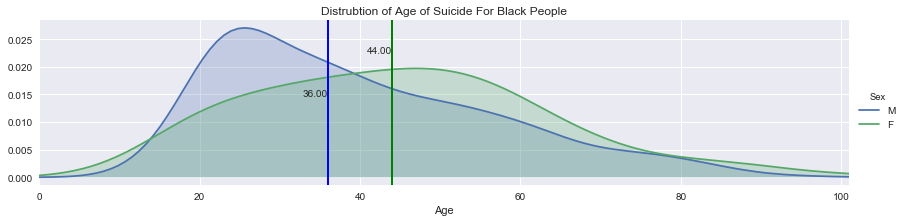

In [435]:
fig = sns.FacetGrid(suicide_black, hue='Sex', aspect=4)

fig.map(sns.kdeplot, 'Mod_age' , shade=True)

oldest = suicide_black['Mod_age'].max()

# Setting the limits
fig.set(xlim=(0,oldest))

# This is how to add a legen
fig.add_legend()
plt.title("Distrubtion of Age of Suicide For Black People")
plt.xlabel('Age')

female_median = suicide_black[suicide_black.Sex == 'F'].Mod_age.median()
male_median = suicide_black[suicide_black.Sex == 'M'].Mod_age.median()

plt.axvline(x=female_median, linewidth=2, color='g')
plt.axvline(x=male_median, linewidth=2, color='b')

plt.figtext(0.34,0.6, "%.2f" %male_median)
plt.figtext(0.41,0.8, "%.2f" %female_median)

For white people there is a slight bimodal distribution, females tend to commit suicide earlier than males at ages 49 and 52 respectively. 

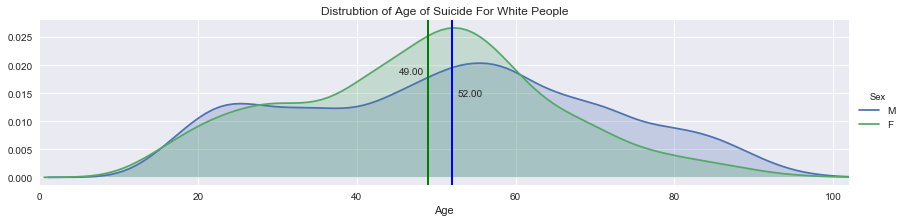

In [436]:
fig = sns.FacetGrid(suicide_white, hue='Sex', aspect=4)

fig.map(sns.kdeplot, 'Mod_age' , shade=True)

oldest = suicide_white['Mod_age'].max()

# Setting the limits
fig.set(xlim=(0,oldest))

# This is how to add a legen
fig.add_legend()
plt.title("Distrubtion of Age of Suicide For White People")
plt.xlabel('Age')

female_median = suicide_white[suicide_white.Sex == 'F'].Mod_age.median()
male_median = suicide_white[suicide_white.Sex == 'M'].Mod_age.median()

plt.axvline(x=female_median, linewidth=2, color='g')
plt.axvline(x=male_median, linewidth=2, color='b')

plt.figtext(0.51,0.6, "%.2f" %male_median)
plt.figtext(0.445,0.7, "%.2f" %female_median)

## Cardiovascular

Here we analyze use the ICD-10 Coding for Cardiovascular Disease:

1. I10 - Malignant Hypertension, Benign Hypertension, Hypertension Unspecified
2. I110 - (Malignant, Benign, Unspecified) Hypertension Heart Disease with Heart Failure
3. I119 - (Malignant, Benign, Unspecified) Hypertension Heart Disease without Heart Failure
4. I209 - Angina Pectoris, NOS 
5. I210 - Myocardial Infarction, Acute, Anterior (initial episode of care)
6. I213 - Myocardial Infarction, Acute, Unspecified (initial episode of care)
7. I251 - ASHD Coronary Artery, ASHD Unspecified, CAD (Coronary Artery Disease)/ASHD
8. I258 - Coronary Atherosclerosis Due to Calcified Coronary Lesion
9. I259 - Chronic Ischemic Heart Disease
10. I509 - Congestive Heart Failure
11. I639 - CVA, Stroke
12. I672 - Cerebral Atherosclerosis
13. I679 - Ischemic Cerebrovascular Disease
14. I739 - Peripheral Vascular Disease

In [437]:
cardiovascular = deaths[deaths.Icd10Code.str.contains('I[2]{1}[0,1,5]+|I[1]{1}[0,1]+|I48|I50|I[6]{1}[3,5,7]+|I73', regex=True)]

In [438]:
search = "I10|I110|I119|I209|I210|I213|I251|I258|I259|I509|I639|I672|I679|I739"
cardiovascular = cardiovascular[cardiovascular.Icd10Code.str.contains(search, regex=True)]

According the barplot below the top three cardiovascular diseases are 

1. I251 - ASHD Coronary Artery, ASHD Unspecified, CAD (Coronary Artery Disease)/ASHD
2. I119 - (Malignant, Benign, Unspecified) Hypertension Heart Disease without Heart Failure
3. I10 - Malignant Hypertension, Benign Hypertension, Hypertension Unspecified

When the plot is split by sex we see that men outnumber women in getting 1 and 3, but women are more likely to die from 2.
 

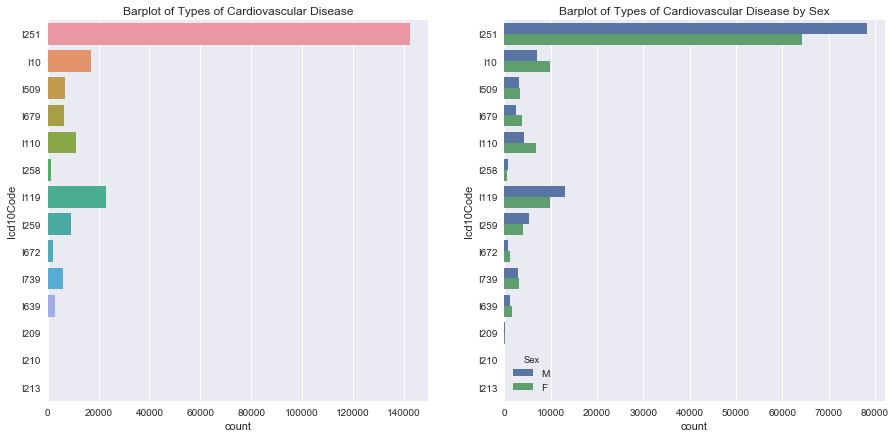

In [439]:
plt.figure(figsize=(15,7)) 

plt.subplot(1,2,1)
sns.countplot(y='Icd10Code',data=cardiovascular)
plt.title('Barplot of Types of Cardiovascular Disease')
plt.subplot(1,2,2)
sns.countplot(y='Icd10Code',data=cardiovascular, hue='Sex')
plt.title('Barplot of Types of Cardiovascular Disease by Sex')

Observing the graph below we can see that the median age of death for people who die from some cardiovascular disease is 82.

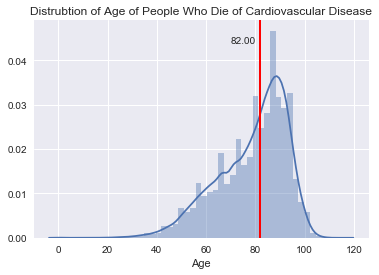

In [440]:
med = cardiovascular.Mod_age.median()
sns.distplot(cardiovascular.Mod_age)
plt.title("Distrubtion of Age of People Who Die of Cardiovascular Disease")
plt.xlabel('Age')
plt.axvline(x=med, linewidth=2, color='r')
plt.figtext(0.58,0.8, "%.2f" %med)

When we split the distribution by sex we see that both sexes have different distributions. Males die from cardiovascular disease earlier than females on average at 78 wheras females are more likely to die from cardiovascular diseas later in life at 86.

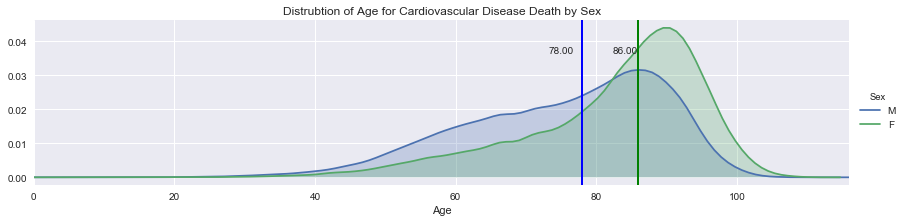

In [441]:
fig = sns.FacetGrid(cardiovascular, hue='Sex', aspect=4)

fig.map(sns.kdeplot, 'Mod_age' , shade=True)

oldest = cardiovascular['Mod_age'].max()

# Setting the limits
fig.set(xlim=(0,oldest))

# This is how to add a legen
fig.add_legend()

plt.title("Distrubtion of Age for Cardiovascular Disease Death by Sex")
plt.xlabel('Age')

female_median = cardiovascular[cardiovascular.Sex == 'F'].Mod_age.median()
male_median = cardiovascular[cardiovascular.Sex == 'M'].Mod_age.median()

plt.axvline(x=female_median, linewidth=2, color='g')
plt.axvline(x=male_median, linewidth=2, color='b')

plt.figtext(0.61,0.8, "%.2f" %male_median)
plt.figtext(0.68,0.8, "%.2f" %female_median)

### Cardiovascular Death by Marital Status

I split the cardiovascular death group by marital status and observed their distribution by age. The order of the groups by median age of death in ascending order is Single (66), Divorced (71), Married (78) , and Widowed (89). 

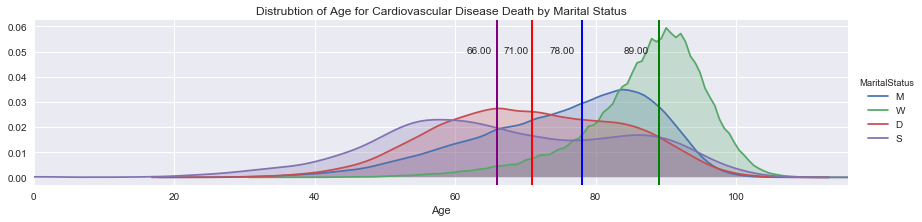

In [442]:
fig = sns.FacetGrid(cardiovascular[cardiovascular.MaritalStatus != 'U'], hue='MaritalStatus', aspect=4)

fig.map(sns.kdeplot, 'Mod_age' , shade=True)

oldest = cardiovascular['Mod_age'].max()

# Setting the limits
fig.set(xlim=(0,oldest))

# This is how to add a legen
fig.add_legend()
plt.title("Distrubtion of Age for Cardiovascular Disease Death by Marital Status")
plt.xlabel('Age')

married_median = cardiovascular[cardiovascular.MaritalStatus == 'M'].Mod_age.median()
widow_median = cardiovascular[cardiovascular.MaritalStatus == 'W'].Mod_age.median()
divorced_median = cardiovascular[cardiovascular.MaritalStatus == 'D'].Mod_age.median()
single_median = cardiovascular[cardiovascular.MaritalStatus == 'S'].Mod_age.median()

plt.axvline(x=married_median, linewidth=2, color='b')
plt.axvline(x=widow_median, linewidth=2, color='g')
plt.axvline(x=divorced_median, linewidth=2, color='r')
plt.axvline(x=single_median, linewidth=2, color='purple')

plt.figtext(0.51,0.8, "%.2f" %single_median)
plt.figtext(0.55,0.8, "%.2f" %divorced_median)
plt.figtext(0.60,0.8, "%.2f" %married_median)
plt.figtext(0.68,0.8, "%.2f" %widow_median)

### Cardiovascular death by race/Ethinicity
The groups are split into black, hispanic, and white in order to see how the race/ethnical attributes affect age of death as a result of cardiovascular disease.

In [443]:
cardio_hispanic = cardiovascular[(cardiovascular.HispanicOriginRaceRecode == 1) | (cardiovascular.HispanicOriginRaceRecode == 4)]
cardio_black = cardiovascular[cardiovascular.RaceRecode3 == 3]
cardio_white = cardiovascular[cardiovascular.RaceRecode3 == 1]

Observing the hispanic distribution conditioned on Sex we see that it closely resembles the overall population distribution of death from cardiovascular disease. However there is a slight shift to the right and both groups on average die earlier than in the population. Males tend to die at the age of 74 wheras females tend to die at 83.

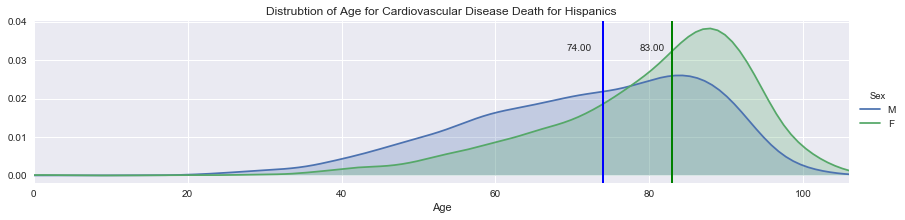

In [444]:
fig = sns.FacetGrid(cardio_hispanic, hue='Sex', aspect=4)

fig.map(sns.kdeplot, 'Mod_age' , shade=True)

oldest = cardio_hispanic['Mod_age'].max()

# Setting the limits
fig.set(xlim=(0,oldest))

# This is how to add a legen
fig.add_legend()
plt.title("Distrubtion of Age for Cardiovascular Disease Death for Hispanics")
plt.xlabel('Age')

female_median = cardio_hispanic[cardio_hispanic.Sex == 'F'].Mod_age.median()
male_median = cardio_hispanic[cardio_hispanic.Sex == 'M'].Mod_age.median()

plt.axvline(x=female_median, linewidth=2, color='g')
plt.axvline(x=male_median, linewidth=2, color='b')

plt.figtext(0.63,0.8, "%.2f" %male_median)
plt.figtext(0.71,0.8, "%.2f" %female_median)

The distribution for the black population does not closely resemble that of the overall population. The female distribution is less left-skewed and the male population resembles a normal distribution. Both groups tend to 
die earlier than than the populations. Males on average tend to die at 68 and females tend to die on average at 78. 

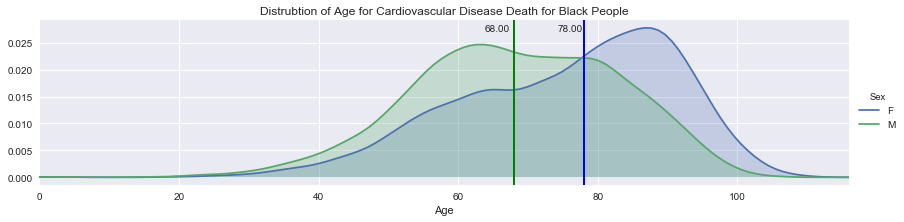

In [445]:
fig = sns.FacetGrid(cardio_black, hue='Sex', aspect=4)

fig.map(sns.kdeplot, 'Mod_age' , shade=True)

oldest = cardio_black['Mod_age'].max()

# Setting the limits
fig.set(xlim=(0,oldest))

# This is how to add a legend
fig.add_legend()
plt.title("Distrubtion of Age for Cardiovascular Disease Death for Black People")
plt.xlabel('Age')

female_median = cardio_black[cardio_black.Sex == 'F'].Mod_age.median()
male_median = cardio_black[cardio_black.Sex == 'M'].Mod_age.median()

plt.axvline(x=female_median, linewidth=2, color='B')
plt.axvline(x=male_median, linewidth=2, color='g')

plt.figtext(0.54,0.9, "%.2f" %male_median)
plt.figtext(0.62,0.9, "%.2f" %female_median)

The white population is more similar to the true population and live on average on year longer than the true population. Males on average die at 79 and females die on average at 87. 

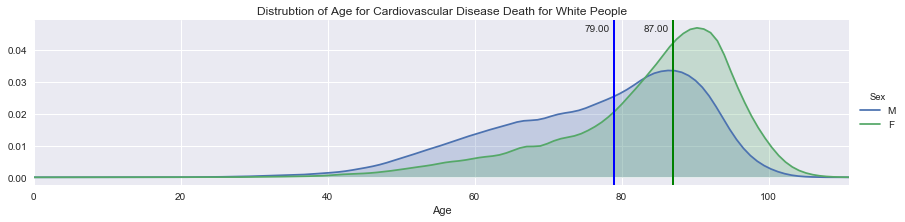

In [446]:
fig = sns.FacetGrid(cardio_white, hue='Sex', aspect=4)

fig.map(sns.kdeplot, 'Mod_age' , shade=True)

oldest = cardio_white['Mod_age'].max()

# Setting the limits
fig.set(xlim=(0,oldest))

# This is how to add a legen
fig.add_legend()
plt.title("Distrubtion of Age for Cardiovascular Disease Death for White People")
plt.xlabel('Age')

female_median = cardio_white[cardio_white.Sex == 'F'].Mod_age.median()
male_median = cardio_white[cardio_white.Sex == 'M'].Mod_age.median()

plt.axvline(x=female_median, linewidth=2, color='g')
plt.axvline(x=male_median, linewidth=2, color='b')

plt.figtext(0.65,0.9, "%.2f" %male_median)
plt.figtext(0.715,0.9, "%.2f" %female_median)

## Cancer

I use the ICD10 codes for neoplasm which range through a large number of neoplasms and can be categorized under the following groups:

1. C00-C14 - Malignant neoplasms of lip, oral cavity and pharynx
2. C15-C26 - Malignant neoplasms of digestive organs
3. C30-C39 - Malignant neoplasms of respiratory and intrathoracic organs
4. C40-C41 - Malignant neoplasms of bone and articular cartilage
5. C43-C44 - Melanoma and other malignant neoplasms of skin
6. C45-C49 - Malignant neoplasms of mesothelial and soft tissue
7. C50 - Malignant neoplasms of breast
8. C51-C58 - Malignant neoplasms of female genital organs
9. C60-C63 - Malignant neoplasms of male genital organs
10. C64-C68 - Malignant neoplasms of urinary tract
11. C69-C72 - Malignant neoplasms of eye, brain and other parts of central nervous system
12. C73-C75 - Malignant neoplasms of thyroid and other endocrine glands
13. C7A - Malignant neuroendocrine tumors
14. C76-C78 - Malignant neoplasms of ill-defined, other secondary and unspecified sites
15. C81-C96 - Malignant neoplasms of lymphoid, hematopoietic and related tissue

In [447]:
search = "C[0,1,3,4,6,7]{1}[0,1,2,3,4,5,6,7,8,9]+|C[2,9]{1}[0,1,2,3,4,5,6]+|C4A|C[5,8]{1}[0,1,2,3,4,5,6,7,8]+|C7A|C7B"
neoplasm = deaths[deaths.Icd10Code.str.contains(search, regex = True)]

In [448]:
#neoplasm.Icd10Code.unique()

Observing the histogram below we can see that the subset of the population that has malignant neoplasms on average tend to die at 72 years of age. The distribution is left skewed and has little variation.

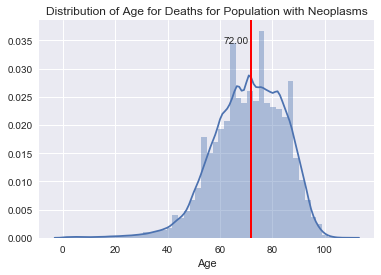

In [449]:
med = neoplasm.Mod_age.median()
sns.distplot(neoplasm.Mod_age)
plt.title('Distribution of Age for Deaths for Population with Neoplasms')
plt.xlabel('Age')

plt.axvline(x=med, linewidth=2, color='r')
plt.figtext(0.55,0.8, "%.2f" %med)

The sex of the individual does not seem to have an effect on their propensity to die from neoplasms. Males on average die of it at 71 and females at 72.

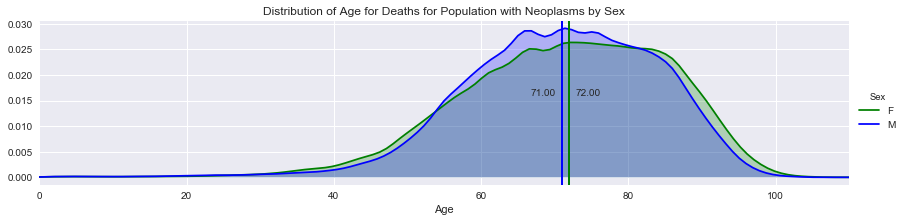

In [450]:
fig = sns.FacetGrid(neoplasm, hue='Sex', aspect=4,palette=['g','b'])

fig.map(sns.kdeplot, 'Mod_age' , shade=True)

oldest = neoplasm['Mod_age'].max()

# Setting the limits
fig.set(xlim=(0,oldest))

# This is how to add a legen
fig.add_legend()

plt.title('Distribution of Age for Deaths for Population with Neoplasms by Sex')
plt.xlabel('Age')

female_median = neoplasm[neoplasm.Sex == 'F'].Mod_age.median()
male_median = neoplasm[neoplasm.Sex == 'M'].Mod_age.median()

plt.axvline(x=female_median, linewidth=2, color='g')
plt.axvline(x=male_median, linewidth=2, color='b')

plt.figtext(0.59,0.6, "%.2f" %male_median)
plt.figtext(0.64,0.6, "%.2f" %female_median)

We observe the graph below which is the set of histograms of individuals who died of neoplams by marital status. Single people die on average earlier than any other group at 60 years, whereas widowed people die on average later in life at 82 years. Divorced people and Married people die on avergage 3 years apart from one another at 67 and 70 respectively. 

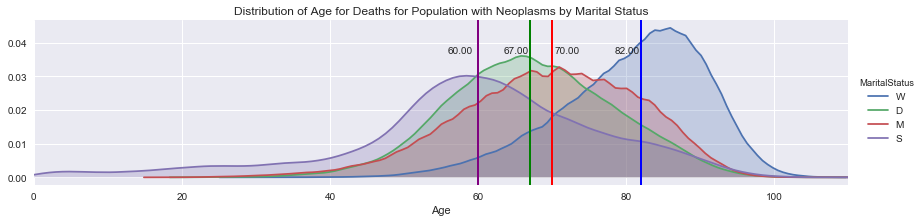

In [451]:
fig = sns.FacetGrid(neoplasm[neoplasm.MaritalStatus != 'U'], hue='MaritalStatus', aspect=4)

fig.map(sns.kdeplot, 'Mod_age' , shade=True)

oldest = neoplasm['Mod_age'].max()

# Setting the limits
fig.set(xlim=(0,oldest))

# This is how to add a legen
fig.add_legend()

plt.title('Distribution of Age for Deaths for Population with Neoplasms by Marital Status')
plt.xlabel('Age')

married_median = neoplasm[neoplasm.MaritalStatus == 'M'].Mod_age.median()
widow_median = neoplasm[neoplasm.MaritalStatus == 'W'].Mod_age.median()
divorced_median = neoplasm[neoplasm.MaritalStatus == 'D'].Mod_age.median()
single_median = neoplasm[neoplasm.MaritalStatus == 'S'].Mod_age.median()

plt.axvline(x=married_median, linewidth=2, color='r')
plt.axvline(x=widow_median, linewidth=2, color='b')
plt.axvline(x=divorced_median, linewidth=2, color='g')
plt.axvline(x=single_median, linewidth=2, color='purple')

plt.figtext(0.49,0.8, "%.2f" %single_median)
plt.figtext(0.55,0.8, "%.2f" %divorced_median)
plt.figtext(0.605,0.8, "%.2f" %married_median)
plt.figtext(0.67,0.8, "%.2f" %widow_median)

Once again I made the three group split of hispanic, black, and white people.

In [452]:
cancer_hispanic = neoplasm[(neoplasm.HispanicOriginRaceRecode == 1) | (neoplasm.HispanicOriginRaceRecode == 4)]
cancer_black = neoplasm[neoplasm.RaceRecode3 == 3]
cancer_white = neoplasm[neoplasm.RaceRecode3 == 1]

Observing both hispanic and black deaths as a result of neoplasms we see that both men and women in both of the groups die on average at 67 years. The difference in sexes for both groups is that males tend to die more from it than females. White people on the other hand live longer with males dying on average at 72 and females dying on average at 73. 

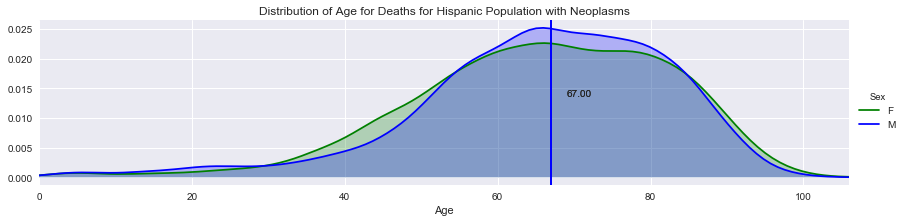

In [453]:
fig = sns.FacetGrid(cancer_hispanic, hue='Sex', aspect=4, palette=['g','b'])

fig.map(sns.kdeplot, 'Mod_age' , shade=True)

oldest = cancer_hispanic['Mod_age'].max()

# Setting the limits
fig.set(xlim=(0,oldest))

# This is how to add a legen
fig.add_legend()

plt.title('Distribution of Age for Deaths for Hispanic Population with Neoplasms')
plt.xlabel('Age')

female_median = cancer_hispanic[cancer_hispanic.Sex == 'F'].Mod_age.median()
male_median = cancer_hispanic[cancer_hispanic.Sex == 'M'].Mod_age.median()

plt.axvline(x=female_median, linewidth=2, color='g')
plt.axvline(x=male_median, linewidth=2, color='b')

plt.figtext(0.63,0.6, "%.2f" %male_median)
plt.figtext(0.63,0.6, "%.2f" %female_median)

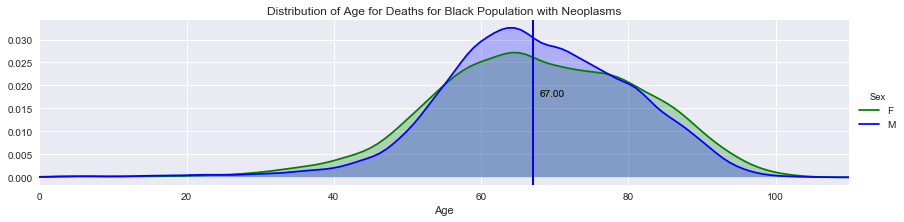

In [454]:
fig = sns.FacetGrid(cancer_black, hue='Sex', aspect=4, palette=['g','b'] )

fig.map(sns.kdeplot, 'Mod_age' , shade=True)

oldest = cancer_black['Mod_age'].max()

# Setting the limits
fig.set(xlim=(0,oldest))

# This is how to add a legen
fig.add_legend()

plt.title('Distribution of Age for Deaths for Black Population with Neoplasms')
plt.xlabel('Age')

female_median = cancer_black[cancer_black.Sex == 'F'].Mod_age.median()
male_median = cancer_black[cancer_black.Sex == 'M'].Mod_age.median()

plt.axvline(x=female_median, linewidth=2, color='g')
plt.axvline(x=male_median, linewidth=2, color='b')

plt.figtext(0.60,0.6, "%.2f" %male_median)
plt.figtext(0.60,0.6, "%.2f" %female_median)

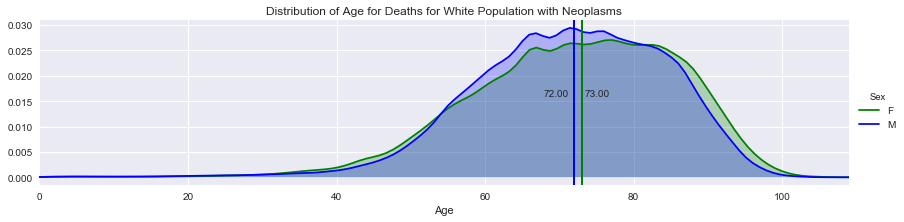

In [455]:
fig = sns.FacetGrid(cancer_white, hue='Sex', aspect=4,palette=['g','b'])

fig.map(sns.kdeplot, 'Mod_age' , shade=True)

oldest = cancer_white['Mod_age'].max()

# Setting the limits
fig.set(xlim=(0,oldest))

# This is how to add a legen
fig.add_legend()

plt.title('Distribution of Age for Deaths for White Population with Neoplasms')
plt.xlabel('Age')

female_median = cancer_white[cancer_white.Sex == 'F'].Mod_age.median()
male_median = cancer_white[cancer_white.Sex == 'M'].Mod_age.median()

plt.axvline(x=female_median, linewidth=2, color='g')
plt.axvline(x=male_median, linewidth=2, color='b')

plt.figtext(0.605,0.6, "%.2f" %male_median)
plt.figtext(0.65,0.6, "%.2f" %female_median)

The neoplasm ICD10 codes are group according to what part of the body they affect. In order to understand which neoplams affect the overall population but also to see if they affect hispanic, white, and black people in different ways.

In [456]:
import re    
def classify_neoplasm(type):
    type1  = 'C[0]{1}[0,1,2,3,4,5,6,7,8,9]+|C[1]{1}[0,1,2,3,4]+'
    type2  = 'C[1]{1}[5,6,7,8,9]+|C[2]{1}[0,1,2,3,4,5,6]+'
    type3  = 'C[3]{1}[0,1,2,3,4,5,6,7,8,9]+'
    type4  = 'C40|C41'
    type5  = 'C43|C44|C4A'
    type6  = 'C[4]{1}[5,6,7,8,9]'
    type7  = 'C50'
    type8  = 'C[5]{1}[1,2,3,4,5,6,7,8]+'    
    type9  = 'C[6]{1}[0,1,2,3]+'
    type10 = 'C[6]{1}[4,5,6,7,8]+'    
    type11 = 'C69|C[7]{1}[0,1,2]+'
    type12 = 'C[7]{1}[4,5,6]+'    
    type13 = 'C7A'
    type14 = 'C[7]{1}[6,7,8,9]+|C80'
    type15 = 'C[8]{1}[1,2,3,4,5,6,7,8]+|C[9]{1}[0,1,2,3,4,5,6]+'
    if(re.match(type1, type)):
        return 'Malignant neoplasms of lip, oral cavity and pharynx'
    elif(re.match(type2, type)):
        return 'Malignant neoplasms of digestive organs'
    elif(re.match(type3, type)):
        return 'Malignant neoplasms of respiratory and intrathoracic organs'
    elif(re.match(type4, type)):
        return 'Malignant neoplasms of bone and articular cartilage'
    elif(re.match(type5, type)):    
        return 'Melanoma and other malignant neoplasms of skin'
    elif(re.match(type6, type)):        
        return 'Malignant neoplasms of mesothelial and soft tissue'
    elif(re.match(type7, type)):            
        return 'Malignant neoplasms of breast'
    elif(re.match(type8, type)):  
        return 'Malignant neoplasms of female genital organs'
    elif(re.match(type9, type)):  
        return 'Malignant neoplasms of male genital organs'
    elif(re.match(type10, type)): 
        return 'Malignant neoplasms of urinary tract'
    elif(re.match(type11, type)):
        return 'Malignant neoplasms of eye, brain and other parts of central nervous system'
    elif(re.match(type12, type)): 
        return 'Malignant neoplasms of thyroid and other endocrine glands'
    elif(re.match(type13, type)): 
        return 'Malignant neuroendocrine tumors'
    elif(re.match(type14, type)):
        return 'Malignant neoplasms of ill-defined, other secondary and unspecified sites'
    elif(re.match(type15, type)):
        return 'Malignant neoplasms of lymphoid, hematopoietic and related tissue'
    
neoplasm['Type'] = neoplasm['Icd10Code'].apply(classify_neoplasm)    

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Observing the following graphs we can see that the top five neoplasms that affect this population are:

1. Malignant neoplasm of respiratory and intrathoracic organs
2. Malignant neoplasms of digestive organs
3. Malignant neoplasms of lymphoid, hematopoietic and related tissue
4. Malignant neoplasms of breast
5. Malignant neoplasms of ill defined, other secondary and inspecified sites

Men are more likely than women to be affected from the (1,2,3, and 5) and women vastly outnumber males at 4.

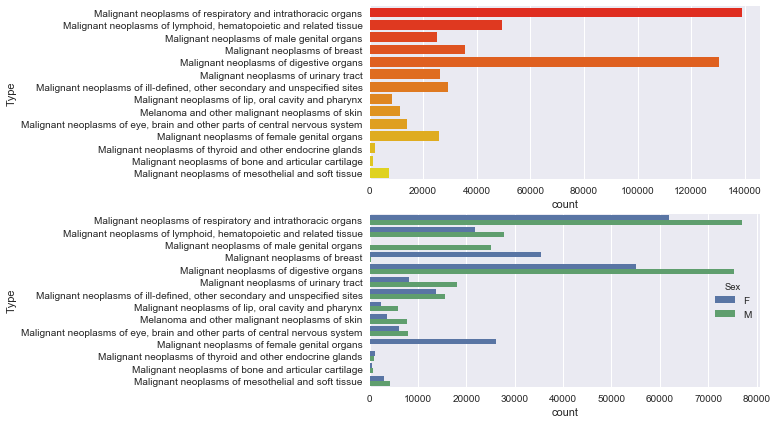

In [457]:
plt.figure(figsize=(7,7)) 

plt.subplot(2,1,1)
sns.countplot(y='Type',data=neoplasm,palette='autumn')
plt.subplot(2,1,2)
sns.countplot(y='Type',data=neoplasm,hue='Sex')

In [458]:
neo_hispanics = neoplasm[(neoplasm.HispanicOriginRaceRecode == 1) | (neoplasm.HispanicOriginRaceRecode == 4)]
neo_black = neoplasm[neoplasm.RaceRecode3 == 3]
neo_white = neoplasm[neoplasm.RaceRecode3 == 1]

Observing the barplots for Hispanic, black, and white people we can see what the top 5 neoplasms affecting each group are. 

Hispanics
1. Malignant neoplasms of digestive organs
2. Malignant neoplasms of respiratory and intrathoracic organs
3. Malignant neoplasms of lymphoid, hematopoietic and related tissue
4. Malignant neoplasms of breast
5. Malignant neoplasms of female genital organs

Black People
1. Malignant neoplasms of digestive organs
2. Malignant neoplasms of respiratory and intrathoracic organs
3. Malignant neoplasms of breast
4. Malignant neoplasms of lymphoid, hematopoietic and related tissue
5. Malignant neoplasms of male genital organs

White People
1. Malignant neoplasms of respiratory and intrathoracic organs
2. Malignant neoplasms of digestive organs
3. Malignant neoplasms of lymphoid, hematopoietic and related tissue
4. Malignant neoplasms of breast
5. Malignant neoplasms of ill defined, other secondary and inspecified sites

All three groups are affected mainly by Malignant neoplasms of respiratory and intrathoracic organs and Malignant neoplasms of lymphoid, hematopoietic and related tissus followed by neoplasms of the breast. Neoplasms in female and male genitals affect hispanic and black people respectively. White peole are affected by ill definged, other secondary and inspecifie site neoplasms.

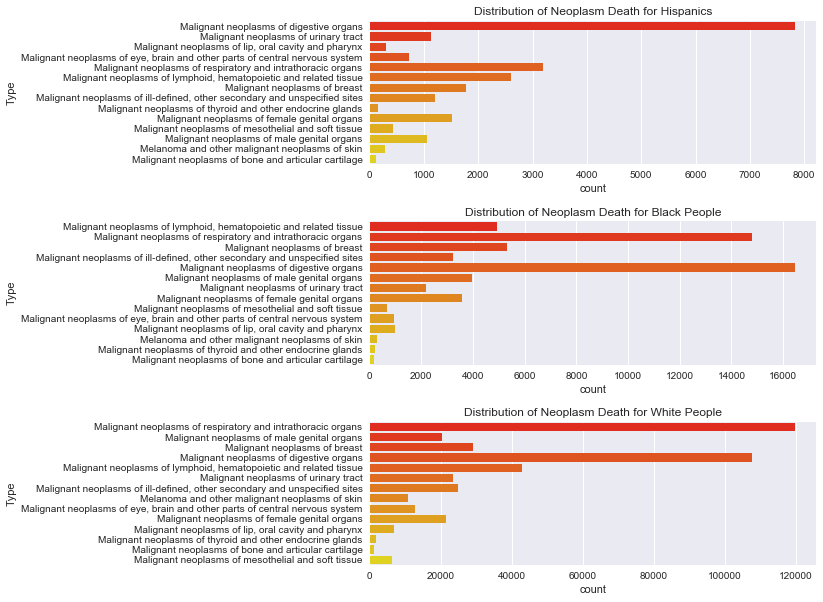

In [459]:
plt.figure(figsize=(8,10)) 

plt.subplot(3,1,1)
sns.countplot(y='Type',data=neo_hispanics,palette='autumn')
plt.title("Distribution of Neoplasm Death for Hispanics")
plt.subplot(3,1,2)
sns.countplot(y='Type',data=neo_black,palette='autumn')
plt.title("Distribution of Neoplasm Death for Black People")
plt.subplot(3,1,3)
sns.countplot(y='Type',data=neo_white,palette='autumn')
plt.title("Distribution of Neoplasm Death for White People")

plt.subplots_adjust(hspace=.4)

In [469]:
#sns.countplot(x='MonthOfDeath',data=suicide,palette='GnBu_d')